# INIT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [2]:
!pip install featuretools # install the missing module

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 19.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

from modules import preprocessing_module as pm
from modules import kmeans_module as km_m
from modules.get_data import get_data
from modules import feature_creation_module as fcm

## Importacion datos

In [4]:
# Diccionario colecciones
db_collections = [
    'calendar',
    'items',
    'prices',
    'tiendas',
    'departments',
    'sales_main',
    'weekly_sales',
    'year_sales',
    'day_sales'
    ]

### CSVs

In [5]:
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
# df_ws = get_data('exp_weekly_sales.csv')
df_ws = get_data('daily_sales_with_events.csv') # Vamos a probar con diarias -> filtramos por años para que no pete la creacion de caracteristicas

/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering/modules/get_data.py:23: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [6]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

,fecha,event
0,2011-02-06,SuperBowl
1,2011-08-01,Ramadan starts
2,2011-11-24,Thanksgiving
3,2012-01-01,NewYear
4,2012-02-05,SuperBowl


,item,category,department
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1


,store_code,region,store
0,NYC_1,New York,Greenwich_Village
1,NYC_2,New York,Harlem
2,NYC_3,New York,Tribeca
3,NYC_4,New York,Brooklyn
4,BOS_1,Boston,South_End


,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event
0,ACCESORIES_1_008,NYC_1,2011-01-29,12,2011,4,0.6118,7.3416,1,Saturday,5,NaN
1,ACCESORIES_1_009,NYC_1,2011-01-29,2,2011,4,2.0748,4.1496,1,Saturday,5,NaN
2,ACCESORIES_1_015,NYC_1,2011-01-29,4,2011,4,0.9310,3.7240,1,Saturday,5,NaN
3,ACCESORIES_1_016,NYC_1,2011-01-29,5,2011,4,0.9310,4.6550,1,Saturday,5,NaN
4,ACCESORIES_1_022,NYC_1,2011-01-29,2,2011,4,9.1238,18.2476,1,Saturday,5,NaN


In [7]:
# Seleccionar solo años 2014 a 2016 de df_ws
df_ws = df_ws[(df_ws['year'] >= 2014) & (df_ws['year'] <= 2016)]

# Cambiamos NaN de event por None
df_ws['event'] = df_ws['event'].fillna('None')

In [8]:
df_ws.shape

(9693001, 12)

# **CREACION CARACTERISTICAS**
___
___  
  
Creamos las caracteristicas generales y luego filtraremos para cada supuesto.

In [9]:
# V2
fc_config = {
    'target_df': 'items',  # Nombre del DataFrame objetivo
    'agg_primitives': [
        'min',               # Mínimo
        'max',               # Máximo
        'mean',              # Promedio
        'std',               # Desviación estándar
        'sum',               # Suma
        'count'              # Totales
    ],
    'trans_primitives': [
        # 'divide_numeric',    # División entre características numéricas -> GENERA MUCHAS!!!
        'percentile'       # Porcentaje de ventas respecto a la tienda de mayor rendimiento
    ],
    'max_depth': 2         # Profundidad máxima de la generación de características
}


feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

In [10]:
print(f'FeatMatrix shape : {feature_matrix.shape}')

print(f'Feat Defs length: {len(feature_defs)}')

FeatMatrix shape : (3049, 109)
Feat Defs length: 109


### Feat Descriptions

In [11]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: category>: The "category".',
 '<Feature: department>: The "department".',
 '<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.month)>: The maximum of the "month" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.raw_earn)>: The maximum of the "raw_earn" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.sell_price)>: The maximum of the "sell_price" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.units)>: The maximum of the "units" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.week)>: The maximum of the "week" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.weekday_number)>: The maximum of the "weekday_number" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.year)>: The maximum of the "year" of all instances of "sales" for ea

__Filtrado caracteristicas usando liberira FeatureTools__
**Feature encode** (codifica categorical)

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-encoding

**Feature selection**

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-selection  
  
- *remove_low_information_features(feature_matrix)*  
Select features that have at least 2 unique values and that are not all null

- *remove_highly_correlated_features(feature_matrix)*  
Removes columns in feature matrix that are highly correlated with another column.

- *remove_highly_null_features(feature_matrix)*  
Removes columns from a feature matrix that have higher than a set threshold of null values.

- *remove_single_value_features(feature_matrix)*  
Removes columns in feature matrix where all the values are the same.

# **PRODUCTOS: PERFORMANCE**
___
___

In [12]:
# V3
substrings = ['units', 'raw_earn']
# substrings = ['raw_earn'] # Nos quedamos solo con las que afectan a los ingresos

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 30
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 30
Shape after filtering: 24
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.units),SUM(sales.raw_earn),MAX(sales.PERCENTILE(raw_earn)),MAX(sales.PERCENTILE(units)),...,STD(sales.PERCENTILE(units)),SUM(sales.PERCENTILE(raw_earn)),SUM(sales.PERCENTILE(units)),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(STD(sales.raw_earn)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.units))
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,65.9148,6.0,15.315095,1.393241,6.6500,7.921939,0.720229,38517.4650,0.984823,0.883327,...,0.175472,1857.415016,821.290270,0.597573,0.137258,0.250246,0.810266,0.743522,0.718924,0.361430
ACCESORIES_1_002,31.6806,6.0,6.694430,1.268571,2.6600,3.270445,0.618826,11715.2518,0.933045,0.883327,...,0.153295,749.350268,511.909244,0.175139,0.137258,0.148901,0.440472,0.202689,0.229911,0.214333
ACCESORIES_1_003,23.7006,6.0,4.806321,1.220238,1.2901,2.159986,0.548854,5652.2340,0.889363,0.883327,...,0.142443,360.562173,329.195805,0.079862,0.137258,0.109216,0.183339,0.075435,0.074779,0.110856
ACCESORIES_1_004,123.4240,20.0,21.065210,3.413471,6.1712,17.589802,2.850305,110402.7680,0.996682,0.985091,...,0.269945,3793.316458,3046.876197,0.865530,0.719908,0.858314,0.769761,0.939324,0.942604,0.866842
ACCESORIES_1_005,34.4736,9.0,6.509380,1.704463,2.6600,3.881594,1.010506,25087.1516,0.942635,0.937677,...,0.212386,1551.616192,1521.452324,0.205969,0.326992,0.477206,0.440472,0.301410,0.549360,0.596261


In [13]:
# Preprocesamiento
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 24


## Kmeans

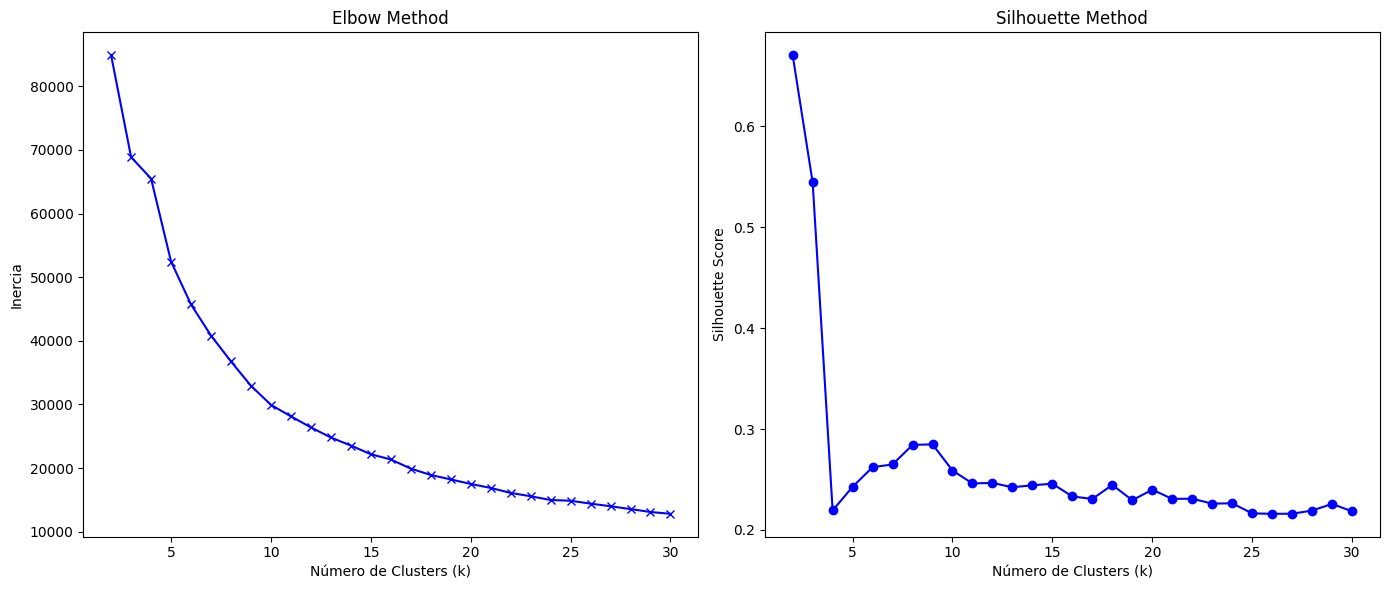

In [14]:
# Elbow and silhouette
km_m.plot_elbow_silhouette(scaled_df, 30)

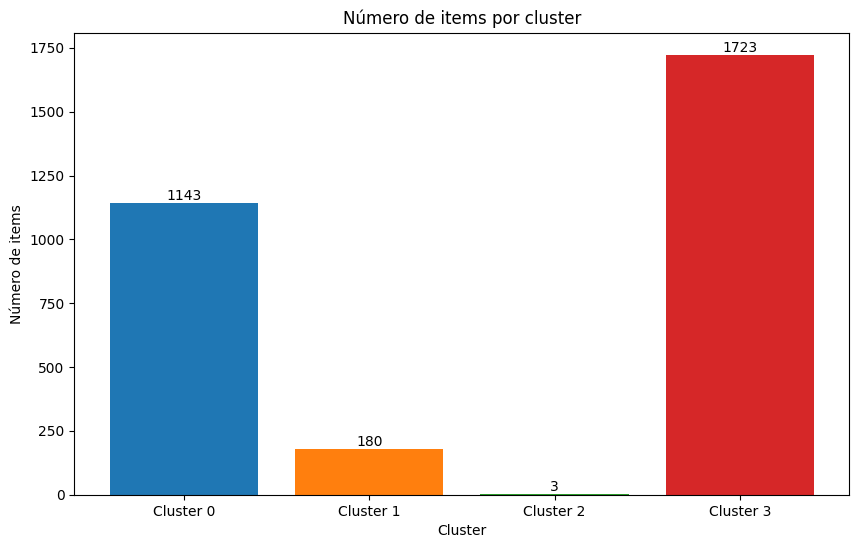

,MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.units),SUM(sales.raw_earn),MAX(sales.PERCENTILE(raw_earn)),MAX(sales.PERCENTILE(units)),...,SUM(sales.PERCENTILE(raw_earn)),SUM(sales.PERCENTILE(units)),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(STD(sales.raw_earn)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.units)),Cluster
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,65.9148,6.0,15.315095,1.393241,6.6500,7.921939,0.720229,38517.4650,0.984823,0.883327,...,1857.415016,821.290270,0.597573,0.137258,0.250246,0.810266,0.743522,0.718924,0.361430,0
ACCESORIES_1_002,31.6806,6.0,6.694430,1.268571,2.6600,3.270445,0.618826,11715.2518,0.933045,0.883327,...,749.350268,511.909244,0.175139,0.137258,0.148901,0.440472,0.202689,0.229911,0.214333,3
ACCESORIES_1_003,23.7006,6.0,4.806321,1.220238,1.2901,2.159986,0.548854,5652.2340,0.889363,0.883327,...,360.562173,329.195805,0.079862,0.137258,0.109216,0.183339,0.075435,0.074779,0.110856,3
ACCESORIES_1_004,123.4240,20.0,21.065210,3.413471,6.1712,17.589802,2.850305,110402.7680,0.996682,0.985091,...,3793.316458,3046.876197,0.865530,0.719908,0.858314,0.769761,0.939324,0.942604,0.866842,0
ACCESORIES_1_005,34.4736,9.0,6.509380,1.704463,2.6600,3.881594,1.010506,25087.1516,0.942635,0.937677,...,1551.616192,1521.452324,0.205969,0.326992,0.477206,0.440472,0.301410,0.549360,0.596261,3


In [15]:
optimal_k = 4

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

## Analisis

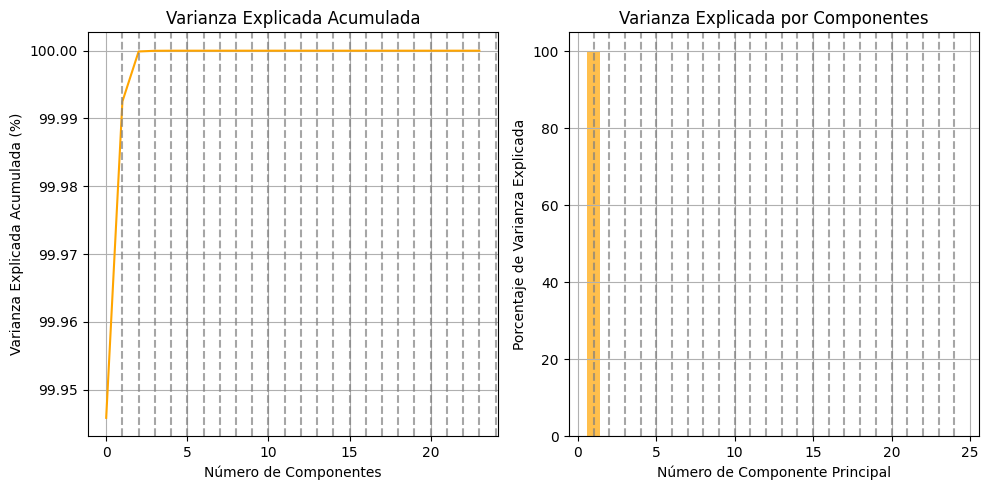

Varianza explicada por cada componente (%): [9.99458428e+01 4.66631767e-02 7.37983009e-03 1.01188998e-04
 1.21493322e-05 5.81331810e-07 1.61842373e-07 5.32412170e-08
 3.66225789e-08 2.41570920e-09 1.71162274e-09 8.06152602e-10
 4.68378728e-10 3.20741367e-10 1.91981318e-10 7.92037832e-11
 5.00290790e-11 4.06997587e-11 2.39037521e-11 2.01493905e-11
 1.23304177e-11 1.04302112e-11 4.63662728e-12 1.05238655e-12]


In [16]:
km_m.view_pca_variance(feature_matrix_with_clusters)

In [ ]:
# # PCA 2 D
# pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

# display(pca_df.head())

In [ ]:
# explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

# display(explained_variance)

Cat cols: 0
Num cols: 24


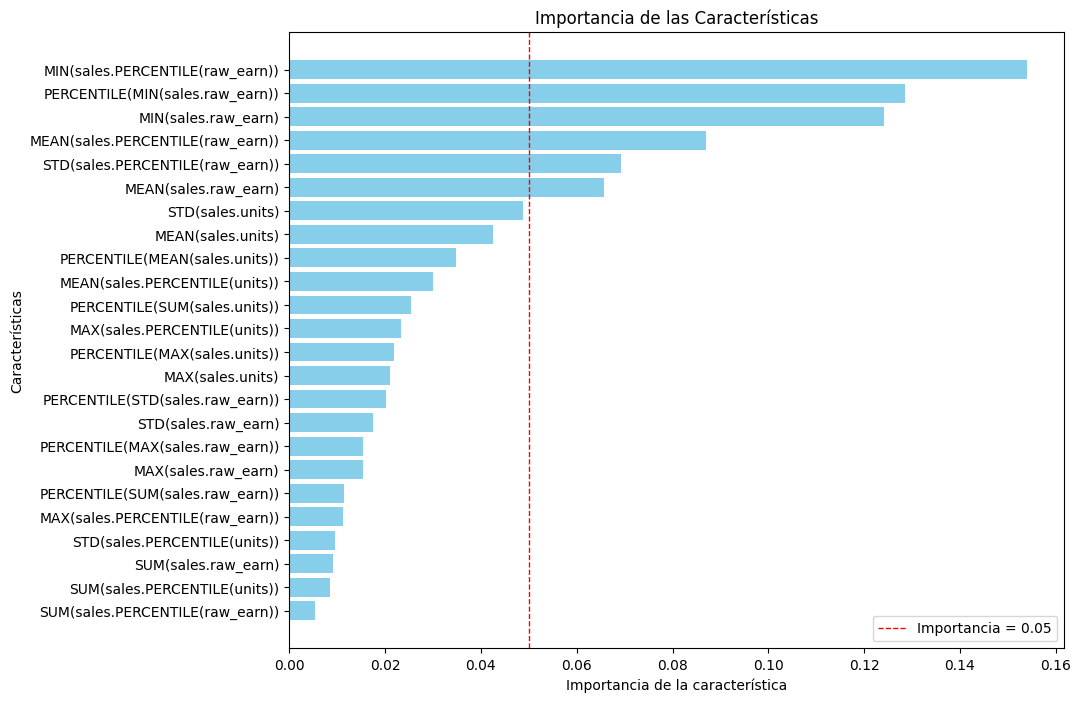

,Feature,Importance
0,MIN(sales.PERCENTILE(raw_earn)),0.154070
1,PERCENTILE(MIN(sales.raw_earn)),0.128471
2,MIN(sales.raw_earn),0.124236
3,MEAN(sales.PERCENTILE(raw_earn)),0.087088
4,STD(sales.PERCENTILE(raw_earn)),0.069328
5,MEAN(sales.raw_earn),0.065655
6,STD(sales.units),0.048835
7,MEAN(sales.units),0.042572
8,PERCENTILE(MEAN(sales.units)),0.034704
9,MEAN(sales.PERCENTILE(units)),0.030026


In [17]:
# Importancia de caracteristicas
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

## Dim redux

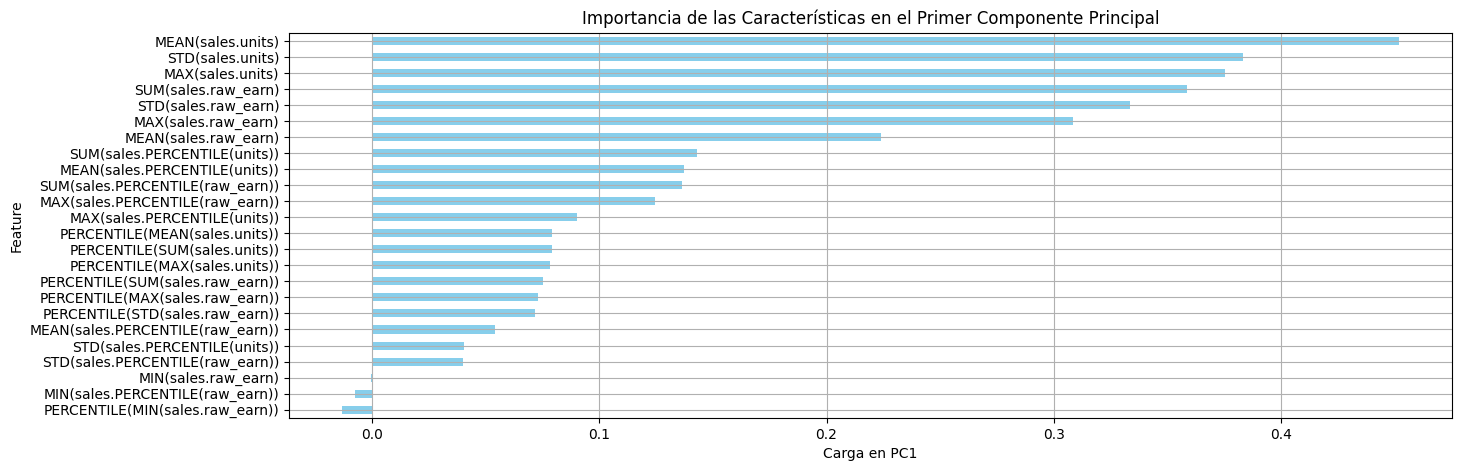

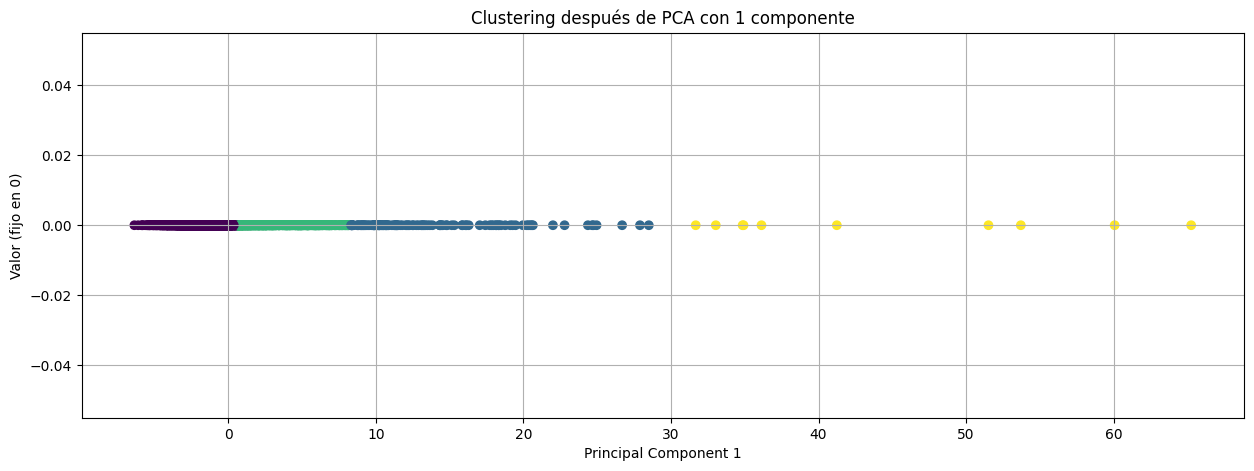

In [18]:
# Dimension redux
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

## Descripcion

,MAX(sales.raw_earn),MAX(sales.units),MEAN(sales.raw_earn),MEAN(sales.units),MIN(sales.raw_earn),STD(sales.raw_earn),STD(sales.units),SUM(sales.raw_earn),MAX(sales.PERCENTILE(raw_earn)),MAX(sales.PERCENTILE(units)),...,SUM(sales.PERCENTILE(units)),PERCENTILE(MAX(sales.raw_earn)),PERCENTILE(MAX(sales.units)),PERCENTILE(MEAN(sales.units)),PERCENTILE(MIN(sales.raw_earn)),PERCENTILE(STD(sales.raw_earn)),PERCENTILE(SUM(sales.raw_earn)),PERCENTILE(SUM(sales.units)),PC1,Cluster
0,0.200950,-0.428571,1.019828,-0.333652,0.866519,0.611957,-0.375891,0.528661,0.155592,-1.245490,...,-0.195317,0.194098,-0.715108,-0.500000,0.622039,0.486877,0.437664,-0.277559,-1.309349,0
1,-0.486829,-0.428571,-0.219258,-0.451548,-0.114307,-0.430564,-0.463333,-0.367689,-1.100853,-1.245490,...,-0.392503,-0.650492,-0.715108,-0.702756,-0.119737,-0.595144,-0.540682,-0.571850,-3.160368,0
2,-0.647150,-0.428571,-0.490644,-0.497255,-0.451057,-0.679447,-0.523670,-0.570456,-2.160831,-1.245490,...,-0.508958,-0.840984,-0.715108,-0.782152,-0.635526,-0.849738,-0.851050,-0.778871,-3.766844,0
3,1.356334,0.571429,1.846316,1.576811,0.748820,2.778777,1.460911,2.932731,0.443341,0.373639,...,1.223181,0.729836,0.488482,0.716535,0.540789,0.878609,0.885171,0.733596,4.000415,2
4,-0.430716,-0.214286,-0.245856,-0.039340,-0.114307,-0.293590,-0.125580,0.079509,-0.868147,-0.380749,...,0.250938,-0.588852,-0.323171,-0.045932,-0.119737,-0.397638,0.098425,0.192257,-1.926622,0


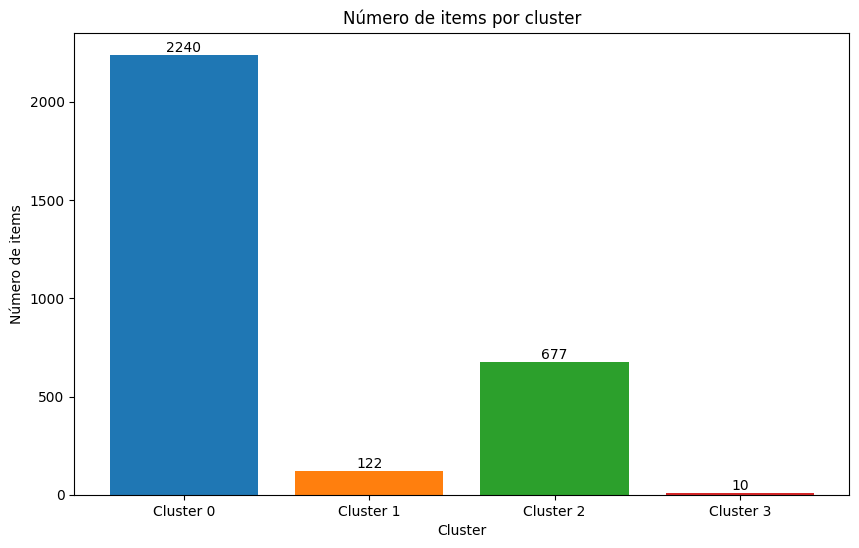

In [19]:
# Descripcion de los clusters
# Ejecutar PCA y clustering
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

In [20]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,0,2,1,3
MEAN(sales.units),-0.084910,1.700419,7.225649,21.284279
STD(sales.units),-0.093708,1.562283,6.645517,14.716114
MAX(sales.units),-0.031920,1.598438,7.456674,10.735714
SUM(sales.raw_earn),-0.084423,1.499167,4.569782,22.427176
STD(sales.raw_earn),-0.079092,1.320384,3.857065,22.415903
MAX(sales.raw_earn),-0.081553,1.310729,4.186421,17.533908
MEAN(sales.raw_earn),0.033655,0.924555,2.579011,15.909341
SUM(sales.PERCENTILE(units)),-0.086487,1.139670,2.378998,2.935786
MEAN(sales.PERCENTILE(units)),-0.153524,1.010820,2.167829,2.762305
SUM(sales.PERCENTILE(raw_earn)),-0.112036,1.040495,2.080706,3.335684


In [21]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

,item,category,department,Cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,0
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,0
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,0


In [22]:
# Crear dataframe con las descripciones de los clusters
# Weekly sales
'''
cluster_summary = {
    0: {
        'cluster_name': 'Moderate Performers',
        'description': 'Productos con ingresos medios y estables, con un rendimiento aceptable, pero sin alcanzar los niveles más altos. Presentan un crecimiento moderado, con baja variabilidad en sus ingresos.'
    },
    1: {
        'cluster_name': 'High Performers',
        'description': 'Productos con ingresos elevados en todas las métricas (SUM, MEAN, y MAX), lo que indica un buen desempeño continuo. Son productos que consistentemente generan buenas ventas con poca variabilidad.'
    },
    2: {
        'cluster_name': 'Top Performers with High Variability',
        'description': 'Productos con los ingresos más altos, pero con una notable variabilidad. Estos productos tienden a generar altos ingresos, pero sus ventas pueden ser impulsadas por promociones o eventos especiales.'
    },
    3: {
        'cluster_name': 'Underperformers',
        'description': 'Productos con ingresos bajos o incluso negativos en algunas métricas. Estos productos están rezagados en términos de rendimiento y podrían estar enfrentando dificultades para generar ingresos de manera constante.'
    }
}
'''
# Daily sales
cluster_summary = {
    0: {
        'cluster_name': 'Underperformers',
        'description': 'Productos con rendimientos negativos o muy bajos tanto en unidades vendidas como en ingresos. Estos productos tienen un rendimiento significativamente inferior al promedio y podrían estar enfrentando problemas para generar ventas.'
    },
    1: {
        'cluster_name': 'Moderate Performers',
        'description': 'Productos con un rendimiento moderado en términos de ventas y ingresos. Aunque no destacan en ingresos máximos o volumen de ventas, muestran una estabilidad aceptable en el mercado con un crecimiento positivo.'
    },
    2: {
        'cluster_name': 'High Performers with Low Variability',
        'description': 'Productos con un alto rendimiento en términos de ventas y unidades, mostrando un buen desempeño tanto en ingresos totales como promedio. Además, presentan una baja variabilidad, lo que indica estabilidad en su éxito de ventas.'
    },
    3: {
        'cluster_name': 'Top Performers with High Variability',
        'description': 'Productos que generan los mayores ingresos y volumen de ventas, pero con una gran variabilidad. Esto sugiere que su éxito podría depender de promociones o eventos específicos que impulsan sus ventas de manera irregular.'
    }
}


cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

,item,category,department,Cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,Underperformers,Productos con rendimientos negativos o muy baj...
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,0,Underperformers,Productos con rendimientos negativos o muy baj...
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,0,Underperformers,Productos con rendimientos negativos o muy baj...
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2,High Performers with Low Variability,Productos con un alto rendimiento en términos ...
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,0,Underperformers,Productos con rendimientos negativos o muy baj...


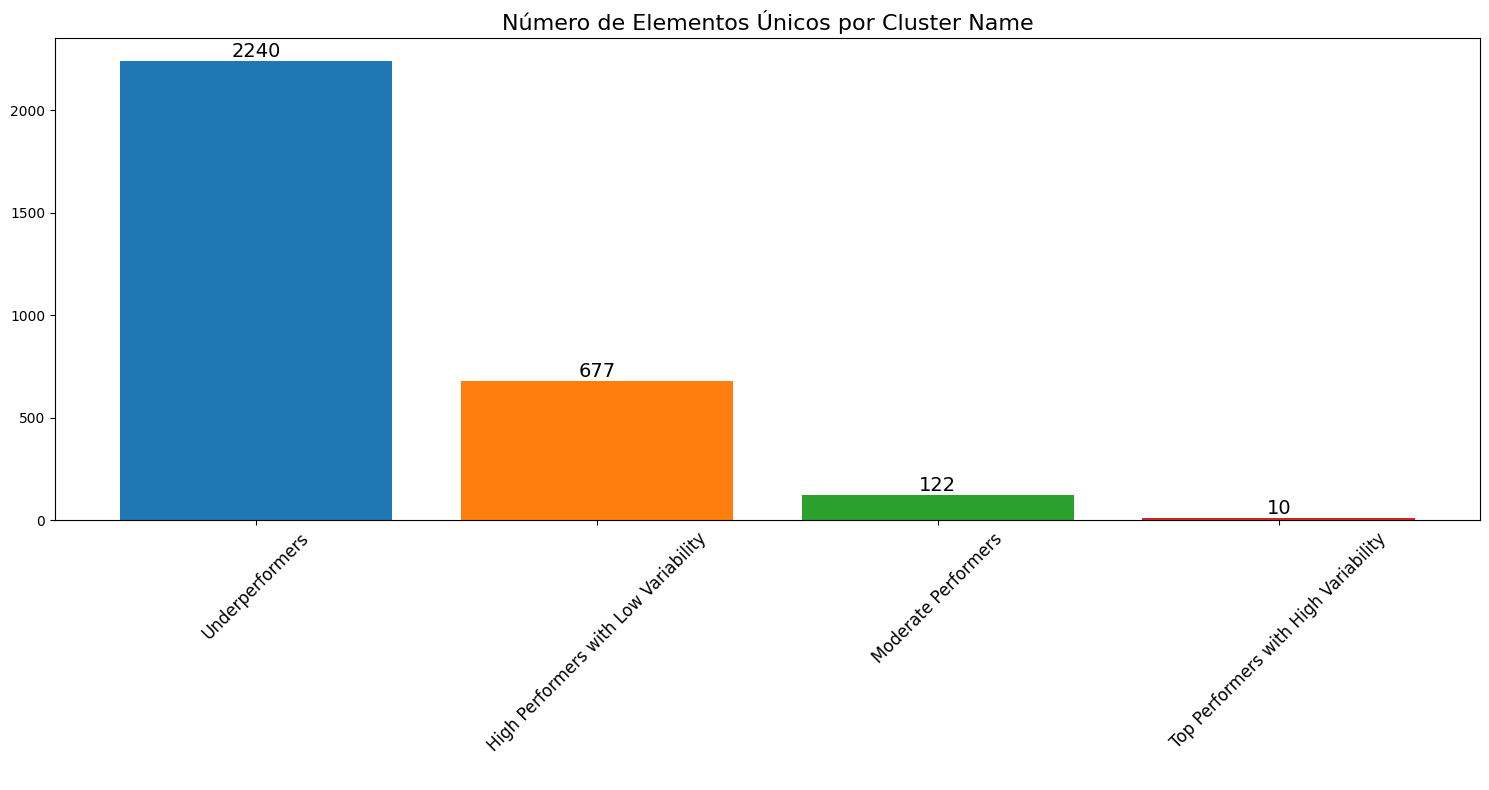

In [23]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos csv

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_raw_earn.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# items_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

# **PRODUCTOS: RANGO DE PRECIOS**
___
___

## Selección caracteristicas

In [24]:
# V3
substrings = ['sell_price'] # Nos quedamos solo con las que afectan al precio de venta

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 15
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 15
Shape after filtering: 10
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MAX(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price),MAX(sales.PERCENTILE(sell_price)),MIN(sales.PERCENTILE(sell_price)),STD(sales.PERCENTILE(sell_price)),SUM(sales.PERCENTILE(sell_price)),PERCENTILE(STD(sales.sell_price)),PERCENTILE(SUM(sales.sell_price))
item,,,,,,,,,,
ACCESORIES_1_001,11.4646,6.6500,0.155606,27643.8904,0.936978,0.795620,0.004588,2333.014799,0.696622,0.878321
ACCESORIES_1_002,5.2801,2.6600,0.094061,9233.6048,0.698160,0.321503,0.013125,1220.891721,0.564775,0.383076
ACCESORIES_1_003,3.9501,1.2502,0.135582,4637.2578,0.564020,0.119489,0.022375,661.957740,0.661200,0.115776
ACCESORIES_1_004,6.1712,6.1712,0.000000,32343.2592,0.757854,0.757854,0.000000,3971.911419,0.126107,0.914726
ACCESORIES_1_005,4.0964,2.6600,0.143314,14705.5839,0.569965,0.321503,0.015901,2114.597356,0.675631,0.623811


## Preprocesamiento

In [25]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 10


## Kmeans

### Elbow & Silhoutte

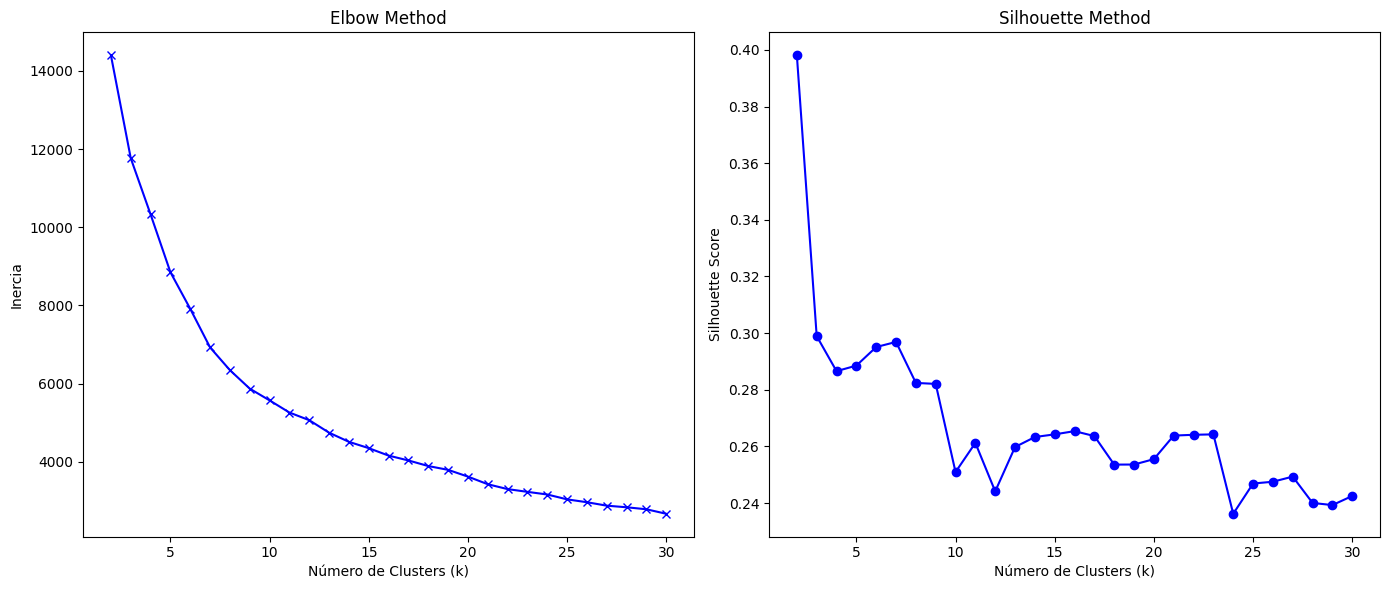

In [26]:
km_m.plot_elbow_silhouette(scaled_df, 30)

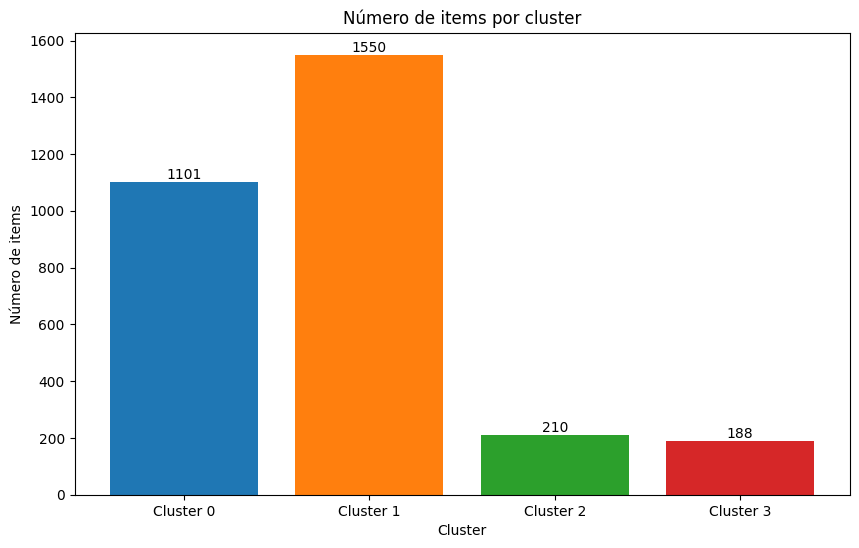

,MAX(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price),MAX(sales.PERCENTILE(sell_price)),MIN(sales.PERCENTILE(sell_price)),STD(sales.PERCENTILE(sell_price)),SUM(sales.PERCENTILE(sell_price)),PERCENTILE(STD(sales.sell_price)),PERCENTILE(SUM(sales.sell_price)),Cluster
item,,,,,,,,,,,
ACCESORIES_1_001,11.4646,6.6500,0.155606,27643.8904,0.936978,0.795620,0.004588,2333.014799,0.696622,0.878321,0
ACCESORIES_1_002,5.2801,2.6600,0.094061,9233.6048,0.698160,0.321503,0.013125,1220.891721,0.564775,0.383076,1
ACCESORIES_1_003,3.9501,1.2502,0.135582,4637.2578,0.564020,0.119489,0.022375,661.957740,0.661200,0.115776,1
ACCESORIES_1_004,6.1712,6.1712,0.000000,32343.2592,0.757854,0.757854,0.000000,3971.911419,0.126107,0.914726,0
ACCESORIES_1_005,4.0964,2.6600,0.143314,14705.5839,0.569965,0.321503,0.015901,2114.597356,0.675631,0.623811,0


In [27]:
optimal_k = 4

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

#### PCAs

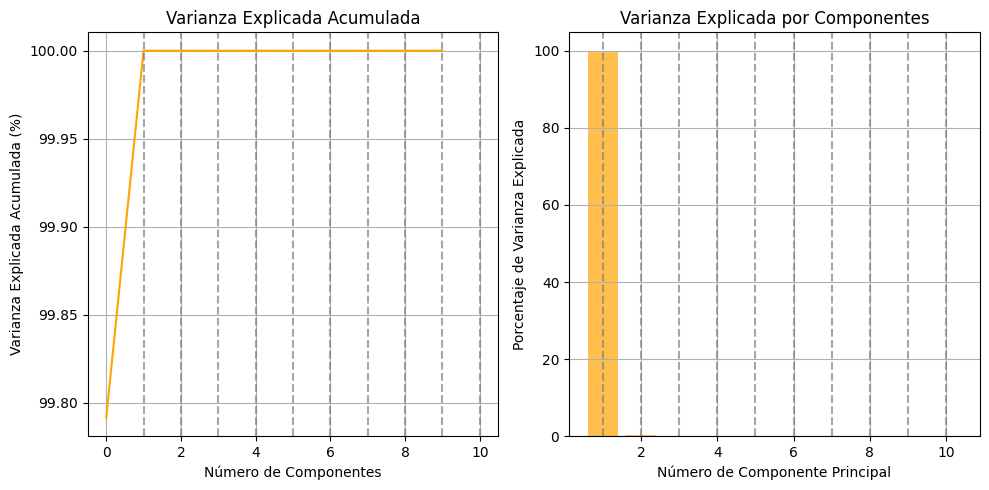

Varianza explicada por cada componente (%): [9.97914492e+01 2.08540330e-01 8.91638895e-06 1.48174859e-06
 3.72266041e-08 1.49284538e-08 7.54459586e-09 5.66144768e-09
 2.76174460e-09 4.21487091e-11]


In [28]:
km_m.view_pca_variance(feature_matrix_with_clusters)

In [ ]:
# pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

# display(pca_df.head())

In [ ]:
# explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

# display(explained_variance)

#### Importancia caracteristicas

Cat cols: 0
Num cols: 10


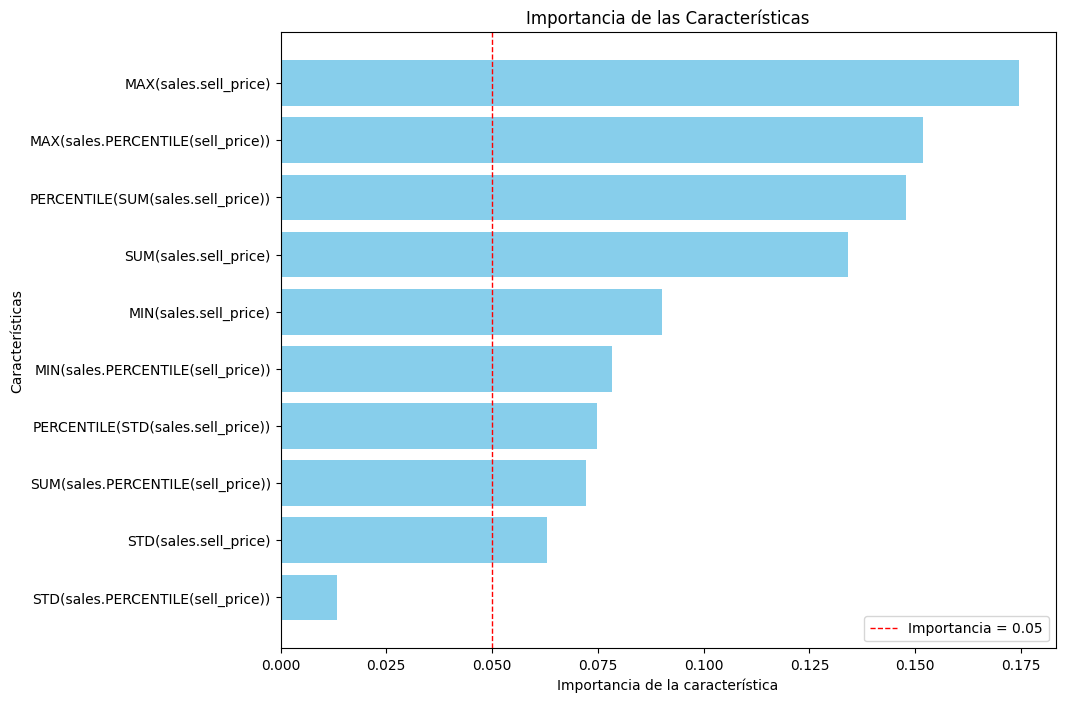

,Feature,Importance
0,MAX(sales.sell_price),0.174435
1,MAX(sales.PERCENTILE(sell_price)),0.151806
2,PERCENTILE(SUM(sales.sell_price)),0.147805
3,SUM(sales.sell_price),0.134212
4,MIN(sales.sell_price),0.090166
5,MIN(sales.PERCENTILE(sell_price)),0.078282
6,PERCENTILE(STD(sales.sell_price)),0.074739
7,SUM(sales.PERCENTILE(sell_price)),0.072108
8,STD(sales.sell_price),0.063011
9,STD(sales.PERCENTILE(sell_price)),0.013436


In [29]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

### Dimension Redux

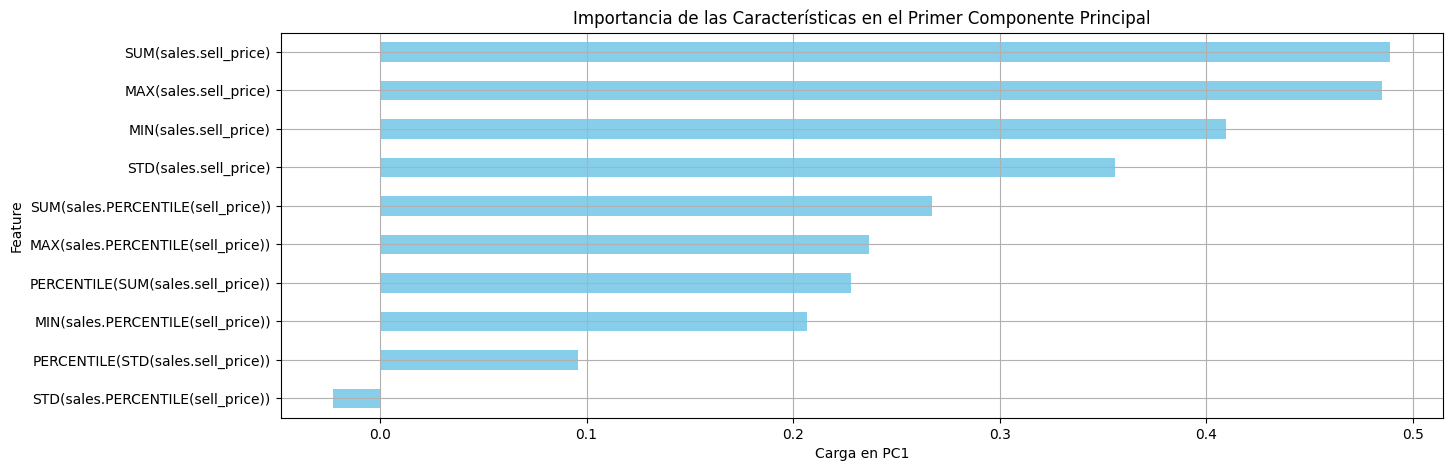

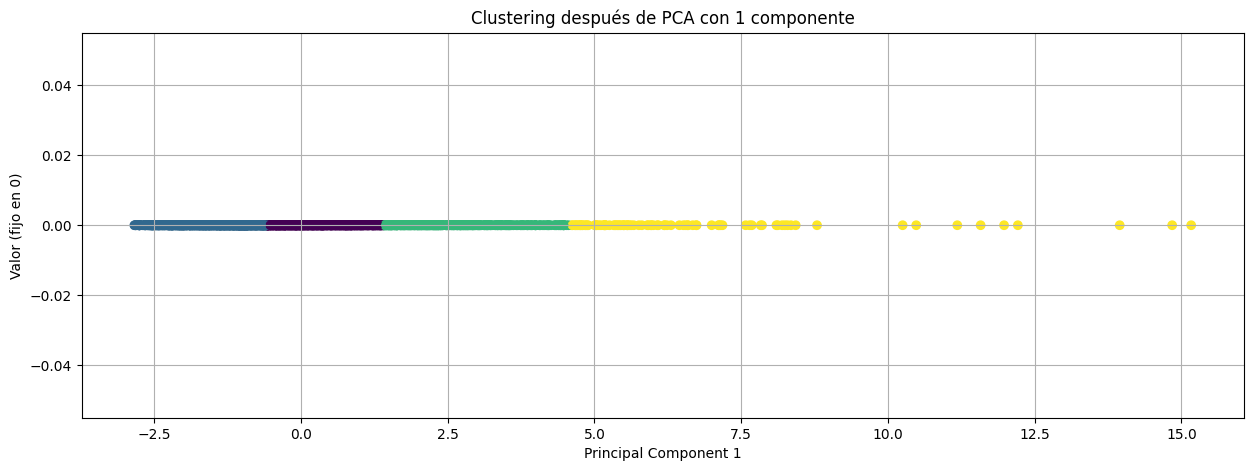

In [30]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

In [ ]:
# El segundo componente es residual
# pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## Descripcion de los clusters

,MAX(sales.sell_price),MIN(sales.sell_price),STD(sales.sell_price),SUM(sales.sell_price),MAX(sales.PERCENTILE(sell_price)),MIN(sales.PERCENTILE(sell_price)),STD(sales.PERCENTILE(sell_price)),SUM(sales.PERCENTILE(sell_price)),PERCENTILE(STD(sales.sell_price)),PERCENTILE(SUM(sales.sell_price)),PC1,Cluster
0,1.519962,0.899901,0.457063,1.314492,0.685873,0.725029,-0.102994,0.695459,0.314849,0.756562,1.997720,2
1,0.201024,-0.083826,0.131269,-0.194442,0.204611,-0.108282,0.347892,-0.087079,0.103548,-0.234252,-0.649528,1
2,-0.082619,-0.431410,0.351062,-0.571166,-0.065703,-0.463342,0.836494,-0.480369,0.258081,-0.769029,-1.395767,1
3,0.391064,0.781854,-0.366643,1.699659,0.324906,0.658650,-0.345340,1.848658,-0.599474,0.829396,1.440141,2
4,-0.051418,-0.083826,0.391995,0.254049,-0.053723,-0.108282,0.494524,0.541771,0.281209,0.247375,-0.229597,0


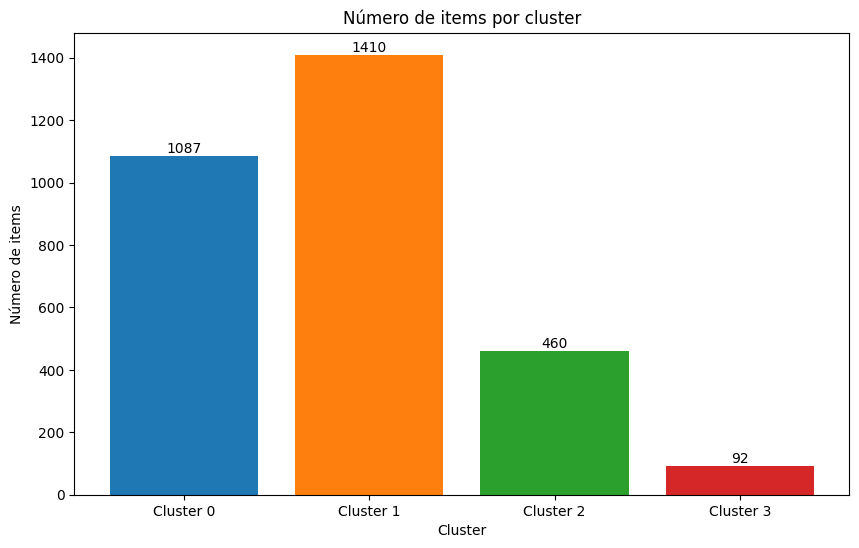

In [31]:
# Ejecutar PCA y clustering
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

### Mostrar Descripcions

In [32]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,2,1,0,3
SUM(sales.sell_price),1.467316,-0.344680,0.347744,4.055645
MAX(sales.sell_price),1.433980,-0.340254,0.364876,3.907704
MIN(sales.sell_price),1.347901,-0.239970,0.383375,3.198593
STD(sales.sell_price),1.188985,-0.016760,0.311214,3.094386
SUM(sales.PERCENTILE(sell_price)),0.964208,-0.362873,0.444901,1.194578
MAX(sales.PERCENTILE(sell_price)),0.618013,-0.533679,0.228854,0.781643
PERCENTILE(SUM(sales.sell_price)),0.677331,-0.448011,0.218508,0.897880
MIN(sales.PERCENTILE(sell_price)),0.731144,-0.297645,0.289993,0.933748
PERCENTILE(STD(sales.sell_price)),0.267800,-0.147270,0.037681,0.472865


### Asignacion clusters a items

In [33]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

,item,category,department,Cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,2
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,1
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,1
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,0


In [34]:
# Crear dataframe con las descripciones de los clusters
# WS
'''
cluster_summary = {
    0: {
        'cluster_name': 'Very High Price',
        'description': 'Productos con precios extremadamente altos en todas las métricas, con una gran variabilidad y dispersion de precios.'
    },
    1: {
        'cluster_name': 'Moderate Price with Low Variability',
        'description': 'Productos de precio moderado, con variación de precios limitada. Los productos parecen estar en un rango estable de precios medios.'
    },
    2: {
        'cluster_name': 'High Price with Stability',
        'description': 'Productos de precio alto con cierta estabilidad en los precios, pero manteniendo variación considerable en el precio máximo y promedio.'
    },
    3: {
        'cluster_name': 'Slightly Above Average Price',
        'description': 'Productos con precios ligeramente superiores al promedio, pero con una variación significativa en los precios máximos y mínimos.'
    }
}
'''
# Daily sales
cluster_summary = {
    0: {
        'cluster_name': 'Moderate Priced Products',
        'description': 'Productos en el rango de precios medio con estabilidad en su precio de venta. Estos productos no presentan grandes fluctuaciones en el precio y se mantienen en un rango de precio moderado tanto en sus máximos como mínimos.'
    },
    1: {
        'cluster_name': 'Low Priced Products',
        'description': 'Productos con precios bajos o negativos en algunas métricas. Estos productos suelen tener precios más accesibles y podrían ser los más competitivos en términos de precio, aunque con cierta variabilidad.'
    },
    2: {
        'cluster_name': 'Premium Priced Products',
        'description': 'Productos de precio alto, tanto en términos de precio total como en las métricas máximas y mínimas. Estos productos se sitúan en el segmento de precio premium y presentan una mayor estabilidad en su valor.'
    },
    3: {
        'cluster_name': 'High Priced with High Variability',
        'description': 'Productos con precios elevados, pero con una alta variabilidad. El precio de estos productos puede fluctuar considerablemente, lo que sugiere que su valor puede estar influenciado por promociones u otros factores externos.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

items_with_cluster_info = items_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

,item,category,department,cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,2,Premium Priced Products,"Productos de precio alto, tanto en términos de..."
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,1,Low Priced Products,Productos con precios bajos o negativos en alg...
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,1,Low Priced Products,Productos con precios bajos o negativos en alg...
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2,Premium Priced Products,"Productos de precio alto, tanto en términos de..."
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,0,Moderate Priced Products,Productos en el rango de precios medio con est...


### Plot clusters con descripcion

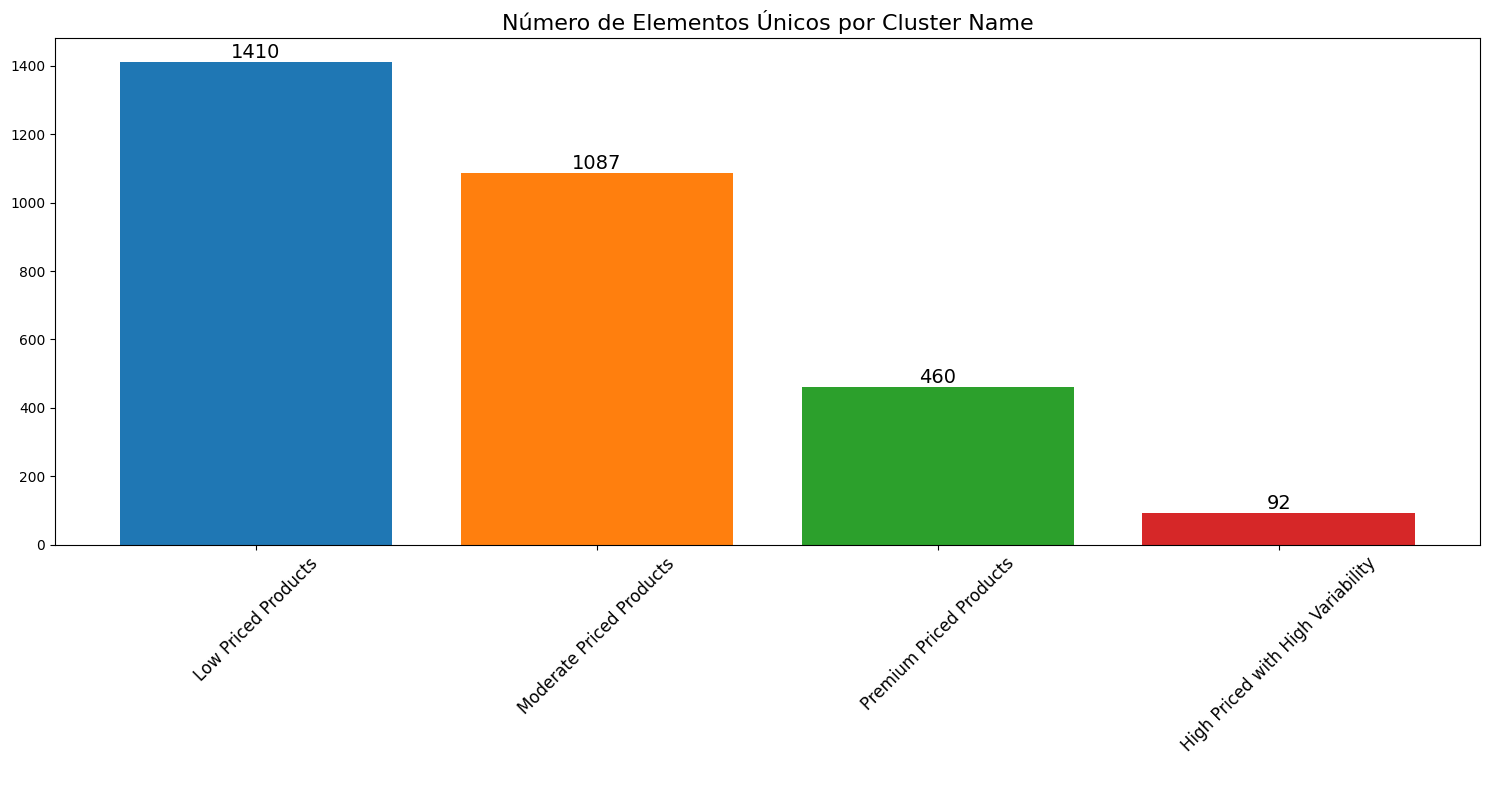

In [35]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_price_range.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# items_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

# **PRODUCTOS: EVENTOS**  
  
**Efecto de eventos en ventas de productos**
___
___

## Creacion caracteristicas

In [ ]:
# V2 -> en weekly sales -> ahora ya esta hecho
# # Añadir año y semana a calendar para poder añadir eventos a weekly sales
# df_cal['fecha'] = pd.to_datetime(df_cal['fecha'])

# df_cal['year'] = df_cal['fecha'].dt.year
# df_cal['week'] = df_cal['fecha'].dt.isocalendar().week

# # Añadir la columna event de df_cal a df_ws usando las columnas year y week (añadir estas dos tambien a df_ws)
# df_ws = df_ws.merge(df_cal[['year', 'week', 'event']], on=['year', 'week'], how='left')

# # Rellenar NaN columna event de df_ws con 'None' (str)
# df_ws['event'] = df_ws['event'].fillna('None')

In [ ]:
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

In [39]:
# OHE para columna event en df_ws usando sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

# Seleccionar la columna 'event' para codificar
events = df_ws[['event']]

# Crear el OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar y transformar los eventos con OHE
event_encoded = ohe.fit_transform(events)

# Crear un DataFrame con las columnas codificadas
event_encoded_df = pd.DataFrame(event_encoded, columns=ohe.get_feature_names_out(['event']))

# Concatenar con el DataFrame original de ventas
df_ws_ohe = pd.concat([df_ws.reset_index(drop=True), event_encoded_df], axis=1)

# Ver el resultado
df_ws_ohe.head()


,id,item,store_code,date,units,year,week,sell_price,raw_earn,month,day_name,weekday_number,event,event_Easter,event_NewYear,event_None,event_Ramadan starts,event_SuperBowl,event_Thanksgiving
0,0,ACCESORIES_1_001,NYC_1,2014-01-01,1,2014,1,10.9858,10.9858,1,Wednesday,2,NewYear,0.0,1.0,0.0,0.0,0.0,0.0
1,1,ACCESORIES_1_004,NYC_1,2014-01-01,2,2014,1,6.1712,12.3424,1,Wednesday,2,NewYear,0.0,1.0,0.0,0.0,0.0,0.0
2,2,ACCESORIES_1_005,NYC_1,2014-01-01,1,2014,1,4.0964,4.0964,1,Wednesday,2,NewYear,0.0,1.0,0.0,0.0,0.0,0.0
3,3,ACCESORIES_1_008,NYC_1,2014-01-01,3,2014,1,0.6118,1.8354,1,Wednesday,2,NewYear,0.0,1.0,0.0,0.0,0.0,0.0
4,4,ACCESORIES_1_010,NYC_1,2014-01-01,3,2014,1,3.9501,11.8503,1,Wednesday,2,NewYear,0.0,1.0,0.0,0.0,0.0,0.0


In [40]:
import featuretools as ft

# Crear un EntitySet
es = ft.EntitySet(id='sales_data')

# Agregar entidades
es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
es = es.add_dataframe(dataframe_name="sales", dataframe=df_ws_ohe, index="id",
                      time_index="week",
                      secondary_time_index={'year': ['units', 'sell_price', 'raw_earn']})

# Definir relaciones
es = es.add_relationship("items", "item", "sales", "item")
es = es.add_relationship("shops", "store_code", "sales", "store_code")

# Generar características automáticas, ahora centradas en "items"
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="items",  # Objetivo: productos
                                      agg_primitives=[
                                          "sum", "mean", "count"  # Agregación sobre ventas
                                      ],
                                      trans_primitives=["year"],  # Primitivas de transformación, usando 'year'
                                      max_depth=2)

feature_matrix.head()

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

,category,department,COUNT(sales),MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.month),...,SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.month),SUM(sales.raw_earn),SUM(sales.sell_price),SUM(sales.units),SUM(sales.week),SUM(sales.weekday_number),SUM(sales.year)
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,2515,0.003976,0.002783,0.984891,0.002386,0.003976,0.001988,6.027833,...,6.0,10.0,5.0,15160.0,38517.4650,27643.8904,3504.0,61813.0,7945.0,5067195.0
ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,1750,0.002286,0.002286,0.988000,0.003429,0.001714,0.002286,6.692571,...,6.0,3.0,4.0,11712.0,11715.2518,9233.6048,2220.0,48065.0,5747.0,3525717.0
ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,1176,0.005952,0.006803,0.977041,0.005102,0.003401,0.001701,6.060374,...,6.0,4.0,2.0,7127.0,5652.2340,4637.2578,1435.0,29262.0,3968.0,2369575.0
ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,5241,0.003625,0.004198,0.984163,0.002480,0.003434,0.002099,5.840870,...,13.0,18.0,11.0,30612.0,110402.7680,32343.2592,17890.0,124913.0,16185.0,10558662.0
ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,3854,0.002854,0.003373,0.984172,0.003373,0.003892,0.002335,6.115205,...,13.0,15.0,9.0,23568.0,25087.1516,14705.5839,6569.0,96670.0,12218.0,7765032.0


## Selección caracteristicas

In [41]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: category>: The "category".',
 '<Feature: department>: The "department".',
 '<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Easter)>: The average of the "event_Easter" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_NewYear)>: The average of the "event_NewYear" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_None)>: The average of the "event_None" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Ramadan starts)>: The average of the "event_Ramadan starts" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_SuperBowl)>: The average of the "event_SuperBowl" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Thanksgiving)>: The average of the "event_Thanksgiving" of all instances of "sales" for each "item" in "items".',


In [42]:
# V3
substrings = ['event', 'raw_earn', 'units'] # Nos quedamos solo con las que afectan a ventas

print(f'Length All features: {len(features_descriptions)}')

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length All features: 29
Length Feats Selected: 16
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 16
Shape after filtering: 15
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MEAN(sales.units),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_None),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn)
item,,,,,,,,,,,,,,,
ACCESORIES_1_001,0.003976,0.002783,0.984891,0.002386,0.003976,0.001988,15.315095,1.393241,10.0,7.0,2477.0,6.0,10.0,5.0,38517.4650
ACCESORIES_1_002,0.002286,0.002286,0.988000,0.003429,0.001714,0.002286,6.694430,1.268571,4.0,4.0,1729.0,6.0,3.0,4.0,11715.2518
ACCESORIES_1_003,0.005952,0.006803,0.977041,0.005102,0.003401,0.001701,4.806321,1.220238,7.0,8.0,1149.0,6.0,4.0,2.0,5652.2340
ACCESORIES_1_004,0.003625,0.004198,0.984163,0.002480,0.003434,0.002099,21.065210,3.413471,19.0,22.0,5158.0,13.0,18.0,11.0,110402.7680
ACCESORIES_1_005,0.002854,0.003373,0.984172,0.003373,0.003892,0.002335,6.509380,1.704463,11.0,13.0,3793.0,13.0,15.0,9.0,25087.1516


## Preprocesamiento

In [43]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

scaled_df.head()

Cat cols: 0
Num cols: 15


,MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MEAN(sales.units),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_None),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn)
0,0.202663,-0.055670,-0.339489,0.040523,0.189719,0.513807,1.019828,-0.333652,-0.090909,-0.1,-0.121822,-0.125,-0.090909,0.2,0.528661
1,-1.014074,-0.375853,0.703641,0.931804,-1.334344,0.758233,-0.219258,-0.451548,-0.636364,-0.4,-0.405693,-0.125,-0.727273,0.0,-0.367689
2,1.625119,2.530723,-2.972974,2.361999,-0.197575,0.277800,-0.490644,-0.497255,-0.363636,0.0,-0.625806,-0.125,-0.636364,-0.4,-0.570456
3,-0.049894,0.854442,-0.583495,0.121505,-0.175273,0.604767,1.846316,1.576811,0.727273,1.4,0.895636,0.750,0.636364,1.4,2.932731
4,-0.604906,0.323863,-0.580489,0.884412,0.133063,0.798901,-0.245856,-0.039340,0.000000,0.5,0.377609,0.750,0.363636,1.0,0.079509


## Kmeans

### Elbow & Silhoutte

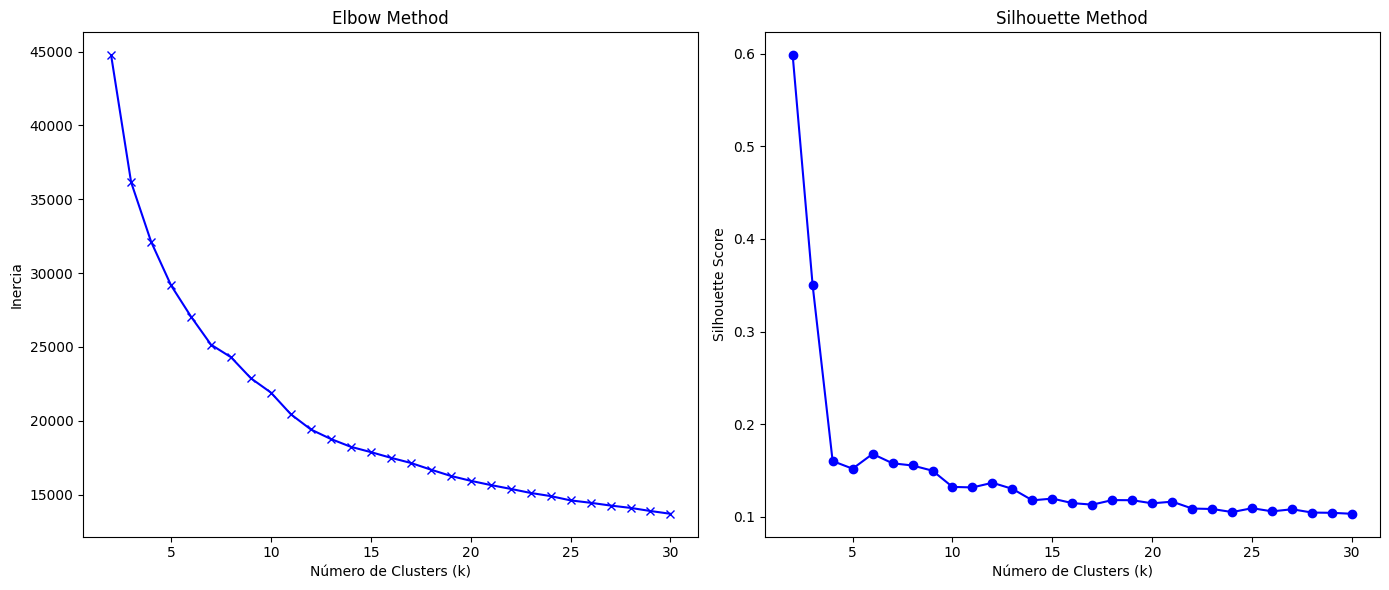

In [44]:
km_m.plot_elbow_silhouette(scaled_df, 30)

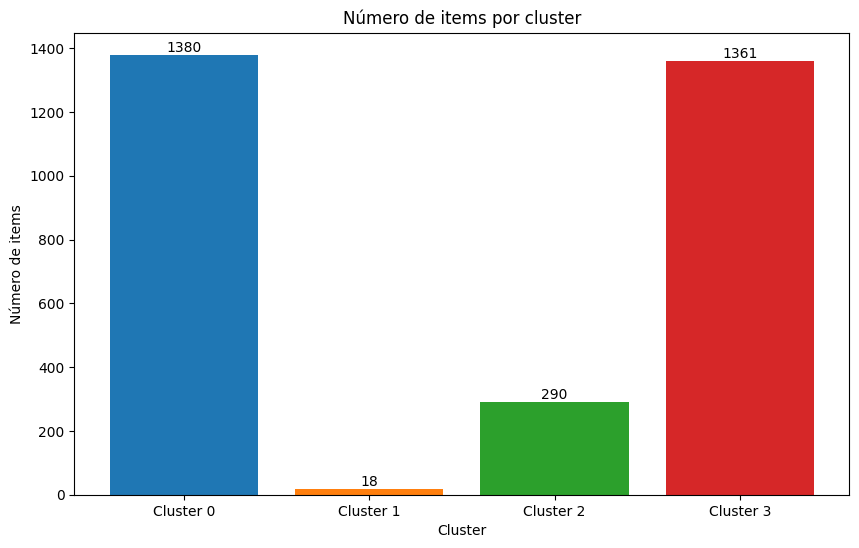

,MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MEAN(sales.units),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_None),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn),Cluster
item,,,,,,,,,,,,,,,,
ACCESORIES_1_001,0.003976,0.002783,0.984891,0.002386,0.003976,0.001988,15.315095,1.393241,10.0,7.0,2477.0,6.0,10.0,5.0,38517.4650,3
ACCESORIES_1_002,0.002286,0.002286,0.988000,0.003429,0.001714,0.002286,6.694430,1.268571,4.0,4.0,1729.0,6.0,3.0,4.0,11715.2518,0
ACCESORIES_1_003,0.005952,0.006803,0.977041,0.005102,0.003401,0.001701,4.806321,1.220238,7.0,8.0,1149.0,6.0,4.0,2.0,5652.2340,3
ACCESORIES_1_004,0.003625,0.004198,0.984163,0.002480,0.003434,0.002099,21.065210,3.413471,19.0,22.0,5158.0,13.0,18.0,11.0,110402.7680,2
ACCESORIES_1_005,0.002854,0.003373,0.984172,0.003373,0.003892,0.002335,6.509380,1.704463,11.0,13.0,3793.0,13.0,15.0,9.0,25087.1516,3


In [50]:
# Apreciamos varias opciones 4 o 5
optimal_k = 4

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

### Analisis

#### PCAs

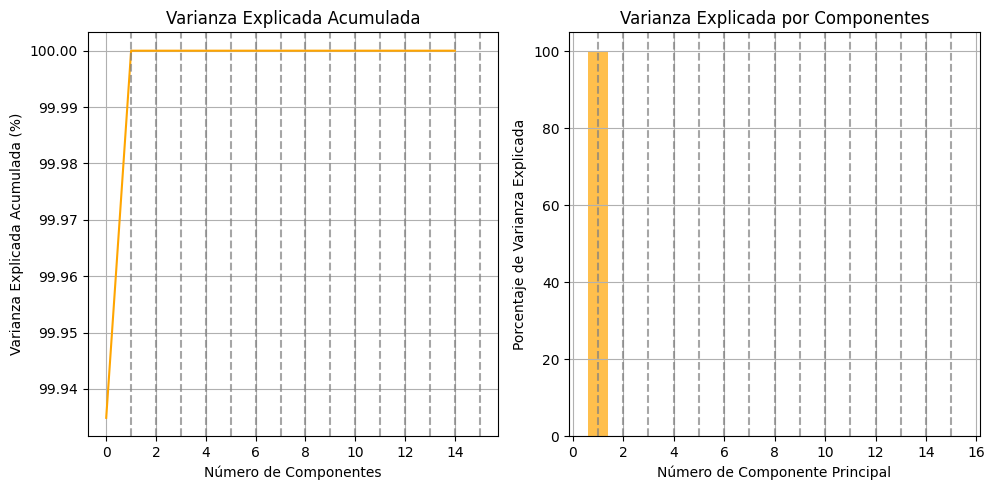

Varianza explicada por cada componente (%): [9.99348651e+01 6.51329331e-02 5.06778026e-07 4.68827268e-07
 2.93517235e-07 2.34119930e-07 1.73910990e-07 1.63308128e-07
 8.21063418e-08 8.78395177e-14 1.71665851e-14 1.46547724e-14
 8.96675910e-15 6.52151179e-15 0.00000000e+00]


In [51]:
km_m.view_pca_variance(feature_matrix_with_clusters)

In [ ]:
# pca_df = km_m.pca_visualization_2d(feature_matrix_with_clusters)

# display(pca_df.head())

In [ ]:
# explained_variance = km_m.pca_variance_plot(feature_matrix_with_clusters, 1)

# display(explained_variance)

#### Importancia caracteristicas

Cat cols: 0
Num cols: 15


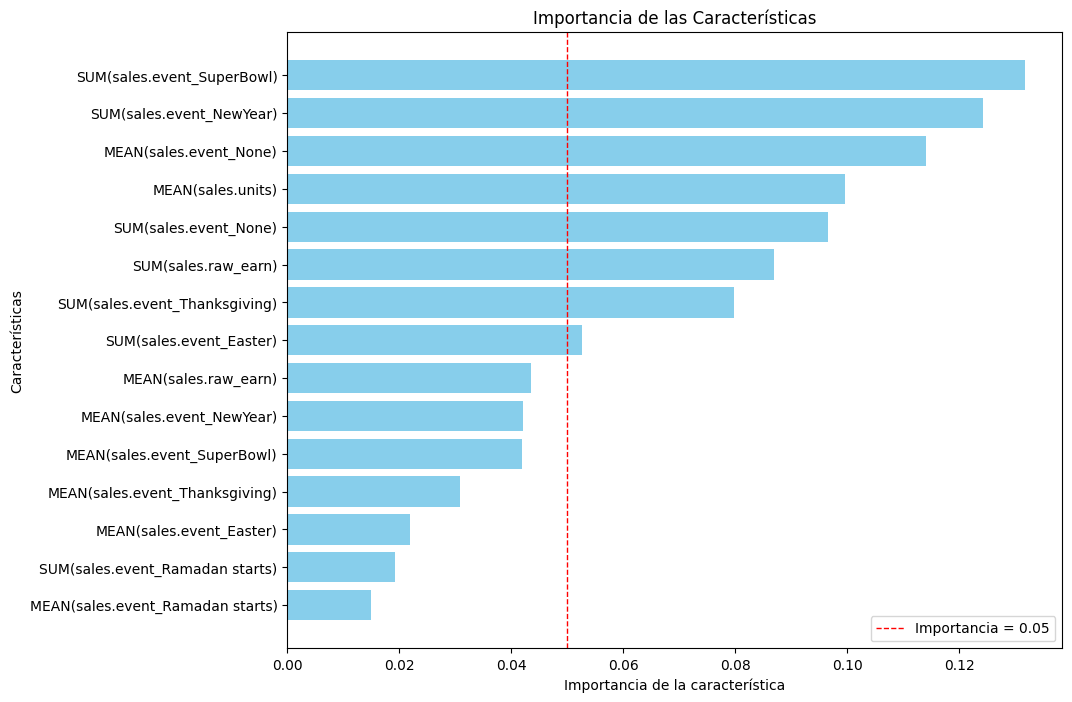

,Feature,Importance
0,SUM(sales.event_SuperBowl),0.131848
1,SUM(sales.event_NewYear),0.124195
2,MEAN(sales.event_None),0.114132
3,MEAN(sales.units),0.099634
4,SUM(sales.event_None),0.096663
5,SUM(sales.raw_earn),0.086892
6,SUM(sales.event_Thanksgiving),0.079792
7,SUM(sales.event_Easter),0.052562
8,MEAN(sales.raw_earn),0.043491
9,MEAN(sales.event_NewYear),0.042040


In [52]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo
preprocessed_df = pm.preprocess_features(feature_matrix_with_clusters[cols_to_scale])

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([preprocessed_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
prices_importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

display(prices_importance_df.head(10))

### Dimension Redux

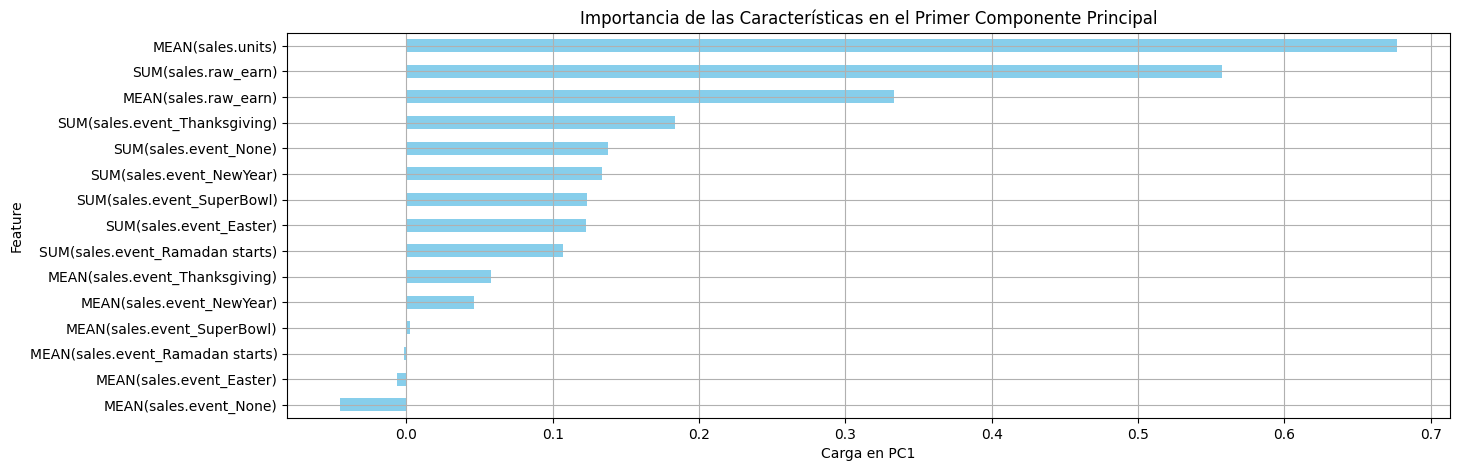

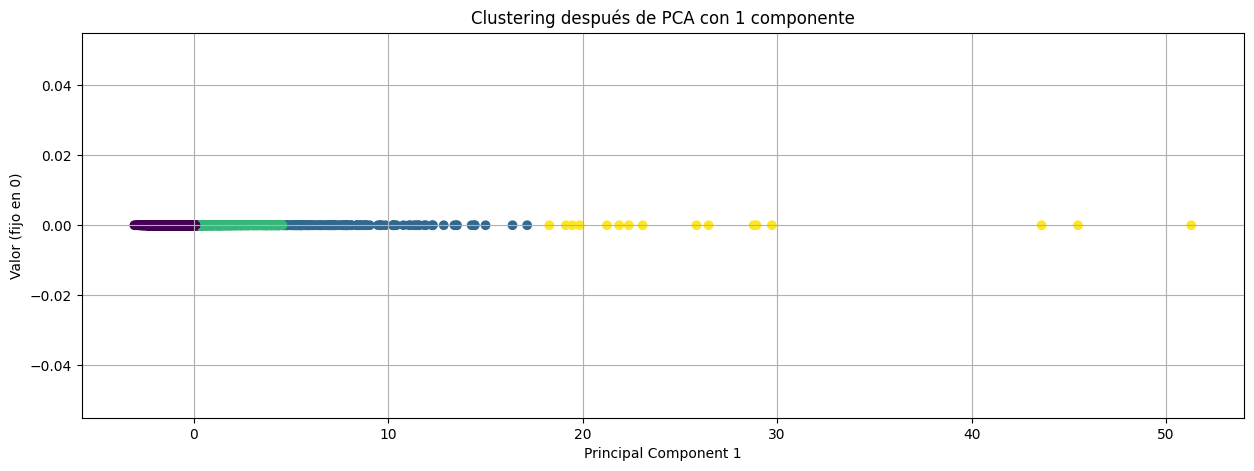

In [53]:
pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=1)

In [ ]:
# El segundo componente es residual
# pca_df, importance_df = km_m.redux_dimensions_pca_and_cluster(preprocessed_df, n_clusters=optimal_k, n_components=2)

## Descripcion de los clusters

,MEAN(sales.event_Easter),MEAN(sales.event_NewYear),MEAN(sales.event_None),MEAN(sales.event_Ramadan starts),MEAN(sales.event_SuperBowl),MEAN(sales.event_Thanksgiving),MEAN(sales.raw_earn),MEAN(sales.units),SUM(sales.event_Easter),SUM(sales.event_NewYear),SUM(sales.event_None),SUM(sales.event_Ramadan starts),SUM(sales.event_SuperBowl),SUM(sales.event_Thanksgiving),SUM(sales.raw_earn),PC1,Cluster
0,0.202663,-0.055670,-0.339489,0.040523,0.189719,0.513807,1.019828,-0.333652,-0.090909,-0.1,-0.121822,-0.125,-0.090909,0.2,0.528661,-0.549402,0
1,-1.014074,-0.375853,0.703641,0.931804,-1.334344,0.758233,-0.219258,-0.451548,-0.636364,-0.4,-0.405693,-0.125,-0.727273,0.0,-0.367689,-1.848073,0
2,1.625119,2.530723,-2.972974,2.361999,-0.197575,0.277800,-0.490644,-0.497255,-0.363636,0.0,-0.625806,-0.125,-0.636364,-0.4,-0.570456,-1.831519,0
3,-0.049894,0.854442,-0.583495,0.121505,-0.175273,0.604767,1.846316,1.576811,0.727273,1.4,0.895636,0.750,0.636364,1.4,2.932731,3.263634,2
4,-0.604906,0.323863,-0.580489,0.884412,0.133063,0.798901,-0.245856,-0.039340,0.000000,0.5,0.377609,0.750,0.363636,1.0,0.079509,-0.516565,0


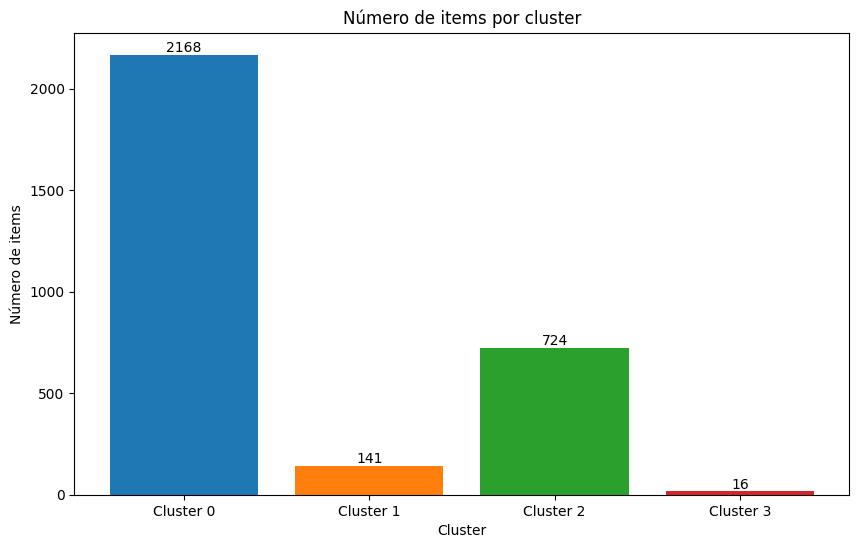

In [54]:
# Ejecutar PCA y clustering
n_components = 1

df_with_pca, importance_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# Mostrar el DataFrame con PCA y clustering
display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
# km_m.plot_items_per_cluster(df_with_pca)
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

### Mostrar Descripcions

In [55]:
# Seleccionamos las features según su importancia en el componente principal
importance_df_filt = importance_df[importance_df['Loading_PC1'] >= 0.05]

importance_df_filt

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


,0,2,1,3
MEAN(sales.units),-0.098030,1.489385,6.210205,19.620829
SUM(sales.raw_earn),-0.133038,1.343887,4.478793,18.222207
MEAN(sales.raw_earn),0.023004,0.806716,2.493388,11.846349
SUM(sales.event_Thanksgiving),-0.196863,0.875138,1.927660,2.550000
SUM(sales.event_None),-0.182045,0.787982,1.330935,1.570470
SUM(sales.event_NewYear),-0.167389,0.757597,1.346099,1.581250
SUM(sales.event_SuperBowl),-0.207313,0.669387,1.141199,1.215909
SUM(sales.event_Easter),-0.192385,0.643898,1.141844,1.409091
SUM(sales.event_Ramadan starts),-0.182138,0.563881,0.975177,1.171875
MEAN(sales.event_Thanksgiving),-0.033901,0.256330,0.619864,0.796615


In [56]:
description_df[sorted(description_df.columns)]


,0,1,2,3
MEAN(sales.units),-0.098030,6.210205,1.489385,19.620829
SUM(sales.raw_earn),-0.133038,4.478793,1.343887,18.222207
MEAN(sales.raw_earn),0.023004,2.493388,0.806716,11.846349
SUM(sales.event_Thanksgiving),-0.196863,1.927660,0.875138,2.550000
SUM(sales.event_None),-0.182045,1.330935,0.787982,1.570470
SUM(sales.event_NewYear),-0.167389,1.346099,0.757597,1.581250
SUM(sales.event_SuperBowl),-0.207313,1.141199,0.669387,1.215909
SUM(sales.event_Easter),-0.192385,1.141844,0.643898,1.409091
SUM(sales.event_Ramadan starts),-0.182138,0.975177,0.563881,1.171875
MEAN(sales.event_Thanksgiving),-0.033901,0.619864,0.256330,0.796615


### Asignacion clusters a items

In [57]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

,item,category,department,Cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,0
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,0
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,0


In [58]:
# Crear dataframe con las descripciones de los clusters
# V2 -> Weekly sales
'''
cluster_summary = {
    0: {
        'cluster_name': 'Negative Impact Products',
        'description': 'Productos que presentan un impacto negativo en ingresos durante la mayoría de los eventos, con una ligera caída en las ventas durante festividades como el Año Nuevo y la Pascua.'
    },
    1: {
        'cluster_name': 'High Seasonal Performance',
        'description': 'Productos con ingresos muy elevados, especialmente durante eventos importantes como el Año Nuevo y el Super Bowl. Su desempeño está fuertemente ligado a eventos específicos.'
    },
    2: {
        'cluster_name': 'Event-Driven Premium Products',
        'description': 'Productos con ingresos muy altos y sensibilidad a eventos como el Año Nuevo y el Super Bowl. Estos productos tienden a rendir mejor en fechas especiales.'
    },
    3: {
        'cluster_name': 'Moderate Event Sensitivity',
        'description': 'Productos que muestran un desempeño positivo moderado durante eventos, sin grandes variaciones. Están ligeramente influenciados por eventos como el Año Nuevo, Pascua y el Super Bowl.'
    },
    4: {
        'cluster_name': 'Event-Resistant Products',
        'description': 'Productos con un impacto marginalmente positivo durante eventos, pero que no dependen fuertemente de los mismos. Muestran estabilidad en ventas, independientemente de festividades.'
    }
}
'''

# Daily sales
cluster_summary = {
    0: {
        'cluster_name': 'No Event Influence',
        'description': 'Productos que no muestran una influencia significativa de eventos en las ventas. Las unidades vendidas y los ingresos son bajos, sin un impacto notable de eventos específicos en su rendimiento.'
    },
    1: {
        'cluster_name': 'Moderate Event Influence',
        'description': 'Productos que experimentan un aumento moderado en ventas y ganancias durante eventos específicos, como el Día de Acción de Gracias y el Año Nuevo. Aunque los eventos tienen cierta influencia, el rendimiento no es excepcionalmente alto.'
    },
    2: {
        'cluster_name': 'High Event-Driven Sales',
        'description': 'Productos con ventas e ingresos elevados, impulsados principalmente por eventos clave como el Día de Acción de Gracias y la Super Bowl. Estos productos dependen en gran medida de los eventos para alcanzar picos de rendimiento.'
    },
    3: {
        'cluster_name': 'Top Event-Driven Performers',
        'description': 'Productos con un rendimiento excepcional en términos de ventas e ingresos durante eventos importantes. Estos productos obtienen la mayor parte de sus ingresos gracias a eventos clave, con un notable incremento durante festividades o celebraciones.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

items_with_cluster_info = items_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

,item,category,department,cluster,cluster_name,description
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,No Event Influence,Productos que no muestran una influencia signi...
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,0,No Event Influence,Productos que no muestran una influencia signi...
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,0,No Event Influence,Productos que no muestran una influencia signi...
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,2,High Event-Driven Sales,"Productos con ventas e ingresos elevados, impu..."
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,0,No Event Influence,Productos que no muestran una influencia signi...


### Plot clusters con descripcion

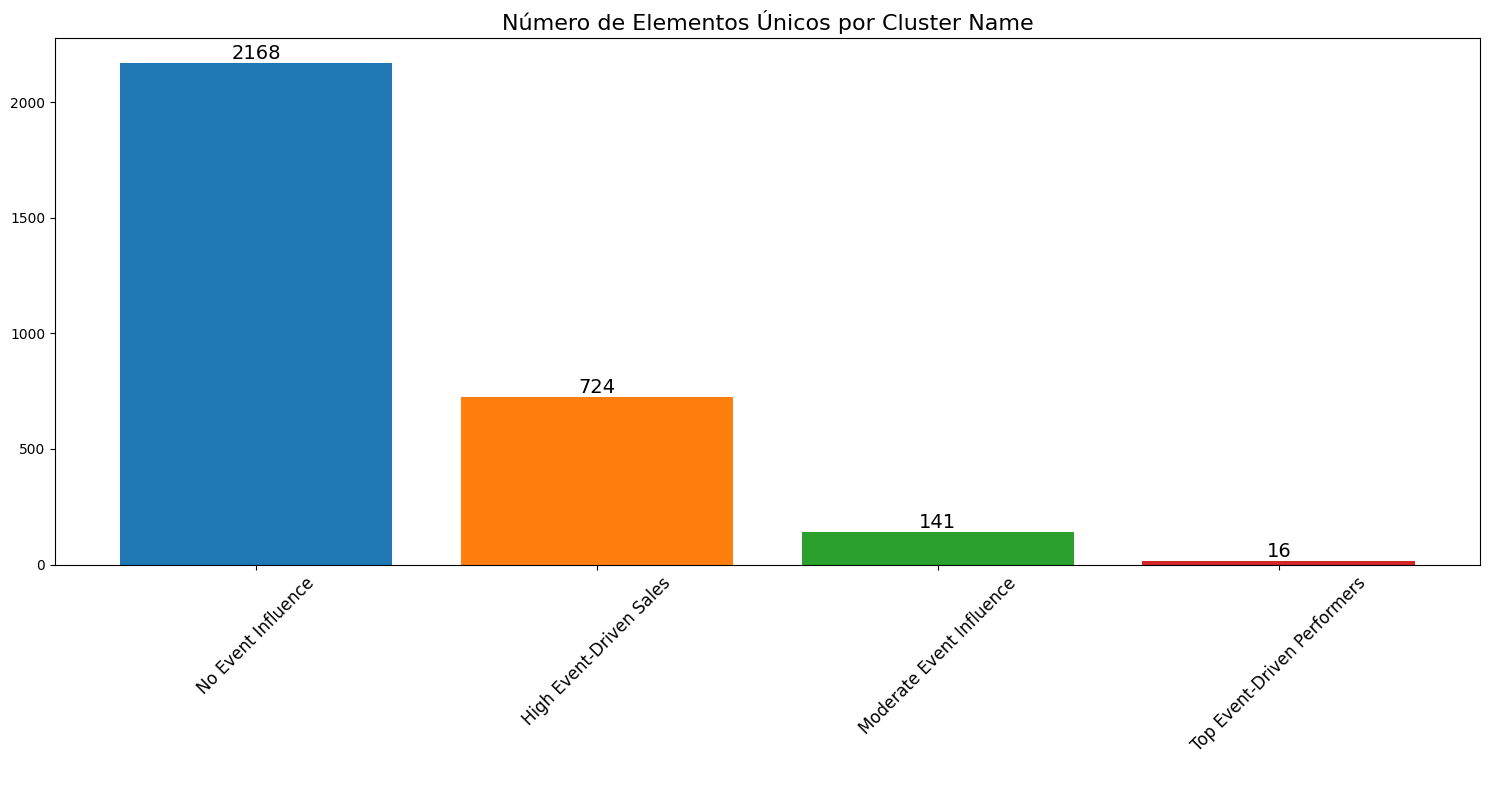

In [59]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_events_influence_sales.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# items_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

___
___